<center>

*******************************************************************************************
<font size="4">
Brahms Quintet &nbsp; &nbsp; &nbsp; <br>
Assessment of Synchronisation &nbsp; &nbsp; <br>
with &nbsp; &nbsp; <br>
Phase-Locking Values &nbsp; &nbsp; <br>
</font>

##### 10 August 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* Replication of experiment described in Sabharwal et al., (2022), using the same raw data (video and annotations of texture).
* The input to this program is preprocessed pose extracted from video.
>
* Reference:
    * Sabharwal, S. R., Varlet, M., Breaden, M., Volpe, G., Camurri, A., & Keller, P. E. (2022). huSync-A model and system for the measure of synchronization in small groups: A case study on musical joint action. *IEEE Access, 10*, 92357-92372.
>
* Instructions:

    Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from statsmodels.stats.anova import AnovaRM
import statsmodels.formula.api as smf
import statsmodels.api as sm

sc_path = 'C:/Users/me/SynCoord/src' # <--- SynCoord's source folder
sys.path.append(sc_path)
import syncoord as sc

***
### Declare paths and set parameters

In [2]:
main_path = 'C:/Users/me'                                 # <---
project_folder = main_path + '/Brahms_Quintet'            # <--- project folder

prop_path = project_folder + '/properties.csv'            # <--- data properties (e.g., FPS)
annot_path = project_folder + '/Brahms_Quintet_annot.csv' # <--- annotations (e.g., ID, Start, Sections)

pose_tracking_path = project_folder + '/pose_tracking'    # <---
prep_path = pose_tracking_path + '/preprocessed'          # <--- preprocessed data (parquet format)

***
### Load and visualise position data

Entries at the top level are excerpts of the musical performance, each corresponding to a group, either "polyphonic" or "homophonic".

In [3]:
data_1 = sc.ptdata.load( prep_path, prop_path, annot_path=annot_path, print_info=True )

index; key; Name; duration (s):
  0; 0; Brahms Quintet - part  1, ex. 1:  Polyphonic; 0:18.352
  1; 1; Brahms Quintet - part  1, ex. 2:  Homophonic; 0:27.594
  2; 2; Brahms Quintet - part  1, ex. 3:  Homophonic; 0:20.354
  3; 3; Brahms Quintet - part  1, ex. 4:  Polyphonic; 0:17.518
  4; 4; Brahms Quintet - part  1, ex. 5:  Homophonic; 0:27.995
  5; 5; Brahms Quintet - part  1, ex. 6:  Homophonic; 0:20.287
  6; 6; Brahms Quintet - part  1, ex. 7:  Polyphonic; 0:27.227
  7; 7; Brahms Quintet - part  1, ex. 8:  Homophonic; 0:23.624
  8; 8; Brahms Quintet - part  1, ex. 9:  Polyphonic; 0:19.286
  9; 9; Brahms Quintet - part  1, ex. 10:  Polyphonic; 0:16.950
  10; 10; Brahms Quintet - part  1, ex. 11:  Polyphonic; 0:20.554
  11; 11; Brahms Quintet - part  1, ex. 12:  Homophonic; 0:16.950
  12; 12; Brahms Quintet - part  1, ex. 13:  Homophonic; 0:16.116
  13; 13; Brahms Quintet - part  1, ex. 14:  Homophonic; 0:30.63
  14; 14; Brahms Quintet - part  2, ex. 1:  Homophonic; 0:18.852
  15; 15;

>
#### Generate index for equally-spaced sections

Each entry at the top level is is divided in three sections.

In [4]:
orig_seclens = sc.ptdata.gensec( data_1, 3, print_info=True, get_lengths=True )

key; sections' length (frames); difference (frames):
  0;  [183, 184, 183];  [1, -1]
  1;  [276, 275, 276];  [-1, 1]
  2;  [203, 204, 203];  [1, -1]
  3;  [175, 175, 175];  [0, 0]
  4;  [280, 279, 280];  [-1, 1]
  5;  [203, 202, 203];  [-1, 1]
  6;  [272, 272, 272];  [0, 0]
  7;  [236, 236, 236];  [0, 0]
  8;  [193, 192, 193];  [-1, 1]
  9;  [169, 170, 169];  [1, -1]
  10;  [205, 206, 205];  [1, -1]
  11;  [169, 170, 169];  [1, -1]
  12;  [161, 161, 161];  [0, 0]
  13;  [300, 301, 300];  [1, -1]
  14;  [188, 189, 188];  [1, -1]
  15;  [252, 253, 252];  [1, -1]
  16;  [235, 236, 235];  [1, -1]
  17;  [239, 240, 239];  [1, -1]
  18;  [273, 273, 273];  [0, 0]
  19;  [188, 189, 188];  [1, -1]
  20;  [165, 164, 165];  [-1, 1]
  21;  [152, 152, 152];  [0, 0]
  22;  [154, 155, 154];  [1, -1]
  23;  [223, 223, 223];  [0, 0]


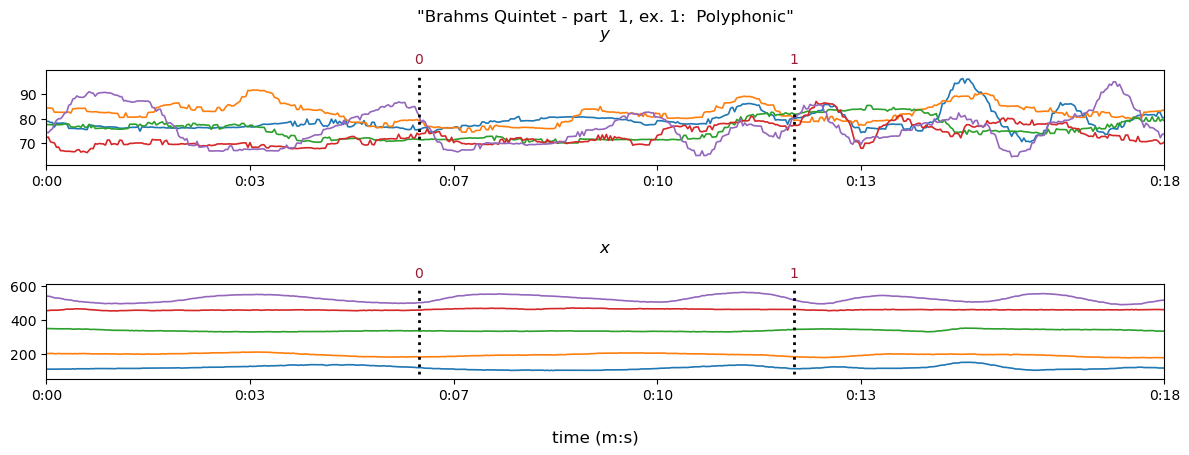

In [5]:
data_1.visualise( top=0 )

In [6]:
data_1.names.dim

['point', 'axis', 'frame']

Dimensions:
* point: Selected bodily point for each musician. In this case, the nose.
* axis: Spatial axes.
* frame: Data-points sampled at regular time-intervals.

***
### Apply low-pass filter to position data

Sabharwal et al., (2022) mentions that the filter has no effect in the final result, however it does have a clear effect.

In [7]:
apply_LPF_1 = False # <---

filter_type = 'savgol'
filter_window_size = 0.5 # <--- (s)
filter_polyorder = 1     # <---

if apply_LPF_1:
    data_2 = sc.ptdata.smooth( data_1, filter_type=filter_type, window_size=filter_window_size,
                               order=filter_polyorder )
    data_2.visualise( top=0, vscale=1.3 )
else:
    data_2 = data_1
    print('Filter not applied to position data.')

Filter not applied to position data.


***
### Reduce to 1 dimension per point

Speed is the Euclidean distance of consecutive data-points (as in Sabharwal et al., 2022). It is very sensitive to noise even after the input (position) has been low-pass filtered.

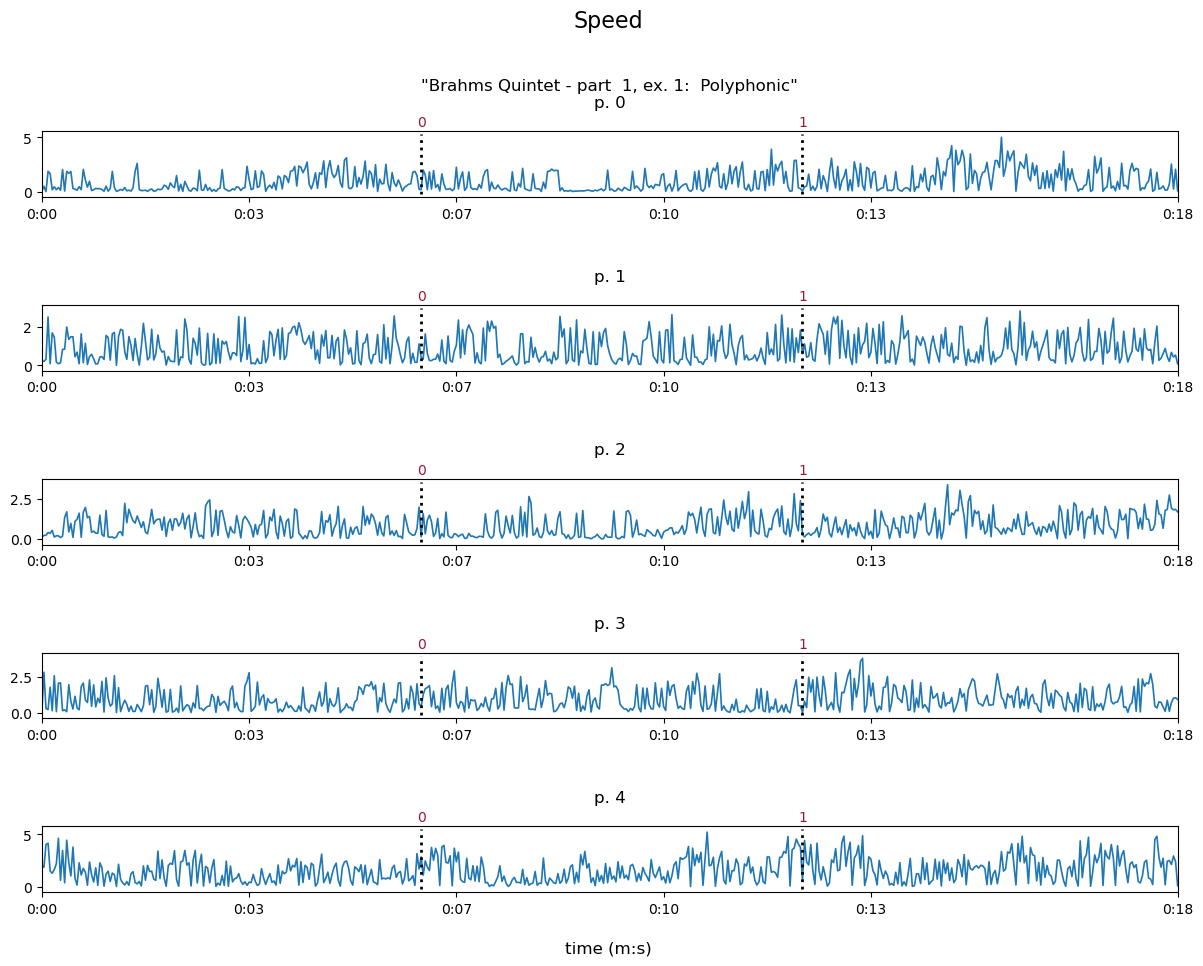

In [8]:
red1D_method = 'speed' # <--- 'norms', 'speed' or spatial axis label ('x','y')

if red1D_method == 'speed':
    data_3 = sc.ptdata.apply( data_2, sc.ndarr.tder, dim=2 )
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( data_2, order=1, axis=-2 )
    n2 = sc.ptdata.norm( data_2, order=2, axis=-2 )
    data_3 = sc.ptdata.apply2( n1, n2, np.add )
elif red1D_method in 'xy':
    data_3 = sc.ptdata.select( data_2, axis='yx'.index(red1D_method) )
else: raise Exception('invalid value for red1D_method')
data_3.visualise( groupby=None, top=0, vscale=0.8 )

***
### Apply low-pass filter to 1-dimensional data

This step is intended to get rid of the noisy artifacts produced by the differentiation (speed).

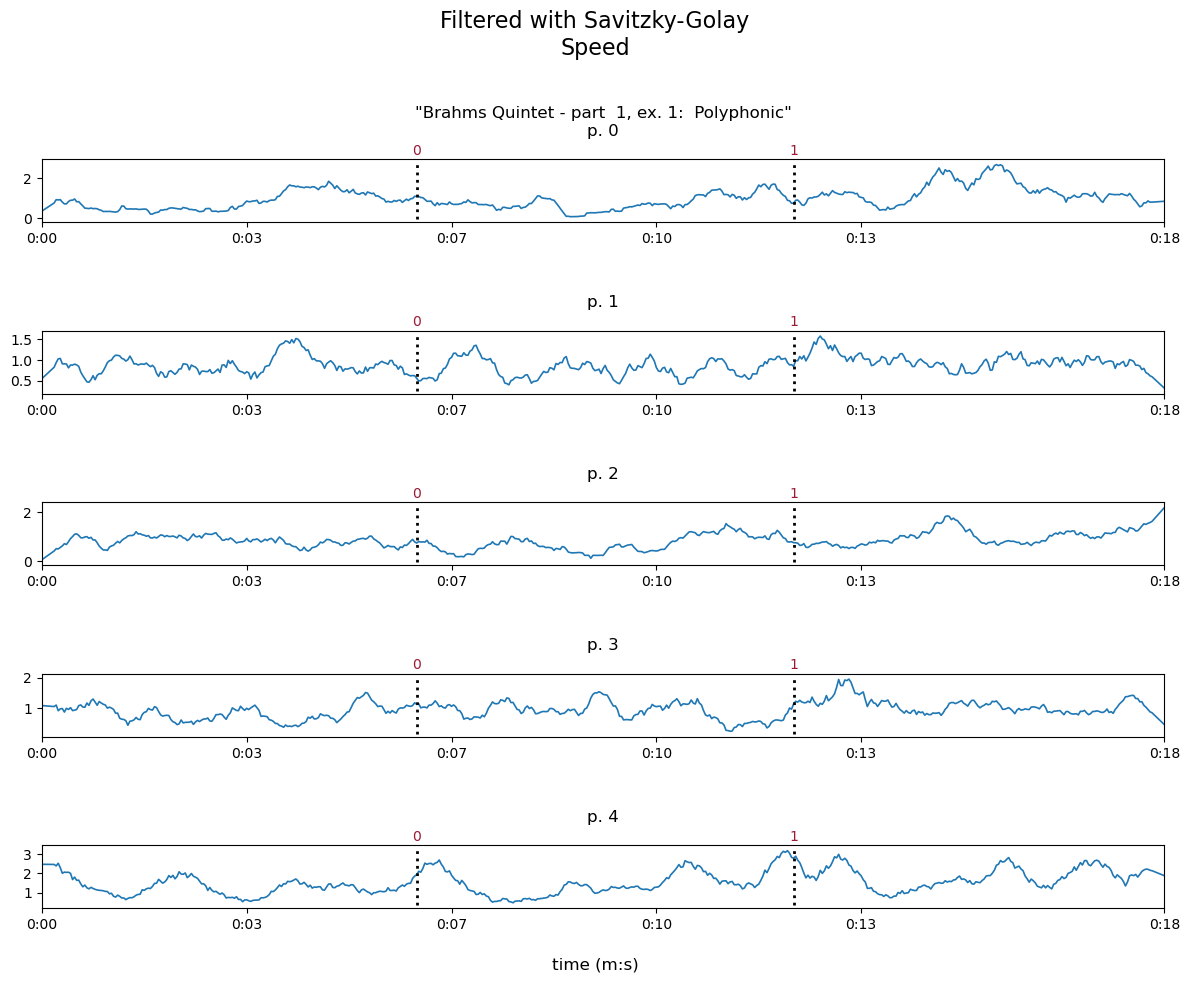

In [9]:
apply_LPF_2 = True # <---

filter_type = 'savgol'
filter_window_size = 0.5 # <--- (s)
filter_polyorder = 1     # <---

if apply_LPF_2:
    data_4 = sc.ptdata.smooth( data_3, filter_type=filter_type, window_size=filter_window_size,
                               order=filter_polyorder )
    data_4.visualise( groupby=None, top=0, vscale=0.8 )
else:
    data_4 = data_3
    print('Filter not applied to 1-D data.')

***
### Phase

Sabharwal et al. (2022) computed phase angles with an FFT upon windows of 30 frames. Also they selected frequency bins from 1 to 10 Hz (inclusive). However, the frequencies of interest are of the swaying motion, presumably at about or less than 2 Hz. Higher frequency bins are of noise.

In [10]:
all_fps = data_4.topinfo.fps.to_list()
if all([all_fps[0] == v for v in all_fps]):
    data_fps = all_fps[0]
    print('fps =',data_fps)
else: raise Exception('fps is not the same for all phrases')

fps = 29.97


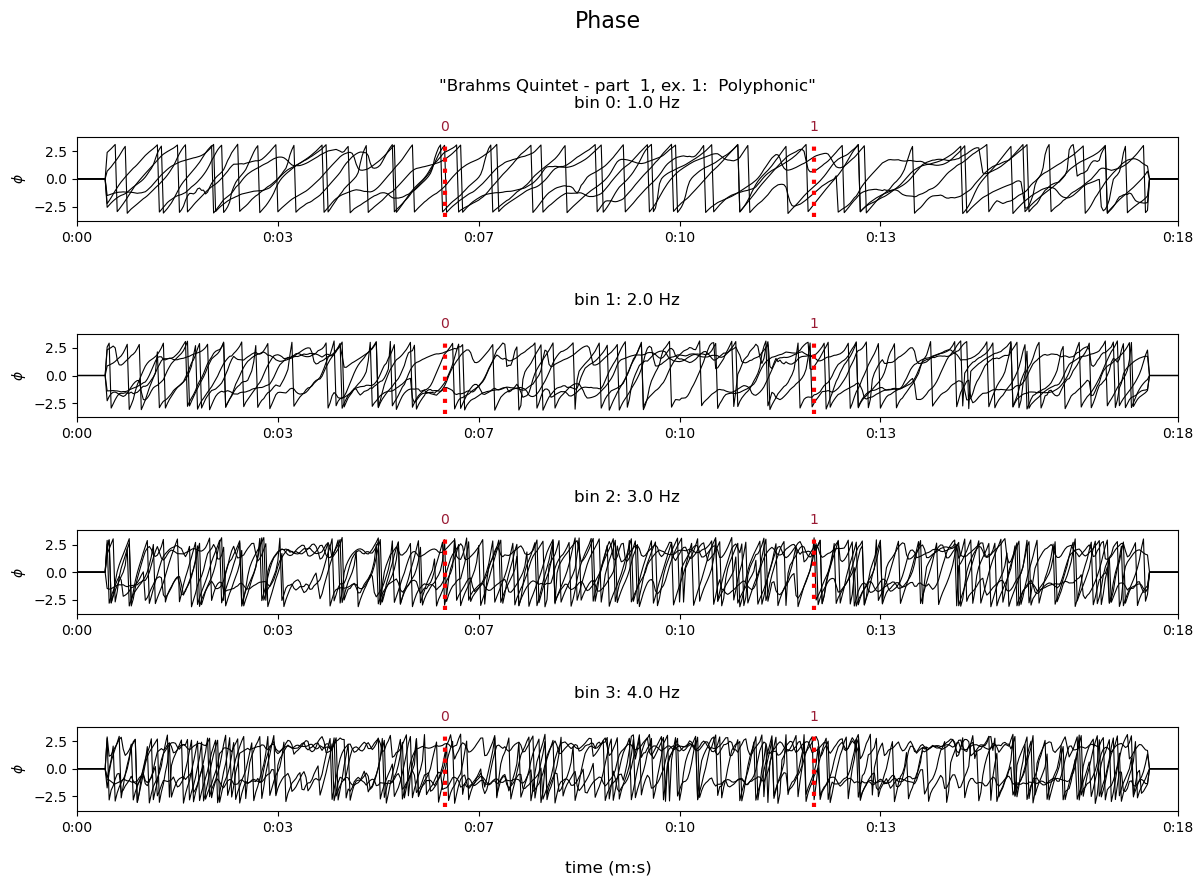

In [11]:
phase_method = 'FFT' # <--- method for phase angles 'peaks' or 'FFT'

if phase_method == 'peaks':
    phase = sc.ptdata.peaks_to_phase( data_4, endstart=True, height=0.2,
                                      distance=int(data_fps/2), prominence=0.1)
    phase.visualise( top=0, groupby=-1, vscale=0.7 )
elif phase_method == 'FFT':

    # fft_win_s = 30/data_fps    # <--- FFT window length in seconds (to get phase)
    fft_win_s = 1    # <--- FFT window length in seconds (to get phase)

    # sel_freq_bin = slice(0,10) # <--- select FFT frequency bins (int, slice, or 'all')
    sel_freq_bin = slice(0,4) # <--- select FFT frequency bins (int, slice, or 'all')

    phase = sc.ptdata.fourier( data_4, fft_win_s, output='phase', mode='same' )
    if sel_freq_bin == 'all':
        phase.visualise( top=0, vscale=0.7 )
    else:
        phase = sc.ptdata.select( phase, frequency=sel_freq_bin )
        vscale_ = 1-(phase.data[0].shape[-2]-1)*0.03
        if isinstance(sel_freq_bin,slice): phase.visualise( top=0, vscale=vscale_ )
        else: phase.visualise( top=0, vscale=1.3 )
    if phase.data[0].shape[-2] == 1: print(phase.labels.dimel[-2][0])
else: raise Exception('Incorrect value for "phase method".')

***
### Phase-Locking Values

#### Pairwise Windowed PLV

Make pairs from dimension 'point' and compute windowed PLV upon dimension 'frame'.
Sabharwal et al., (2022) used a window length of 30 frames with a step of 5 frames. The step  parameter (also known as "hop") doesn't affect the overall result.

In [12]:
phase.names.dim

['point', 'frequency', 'frame']

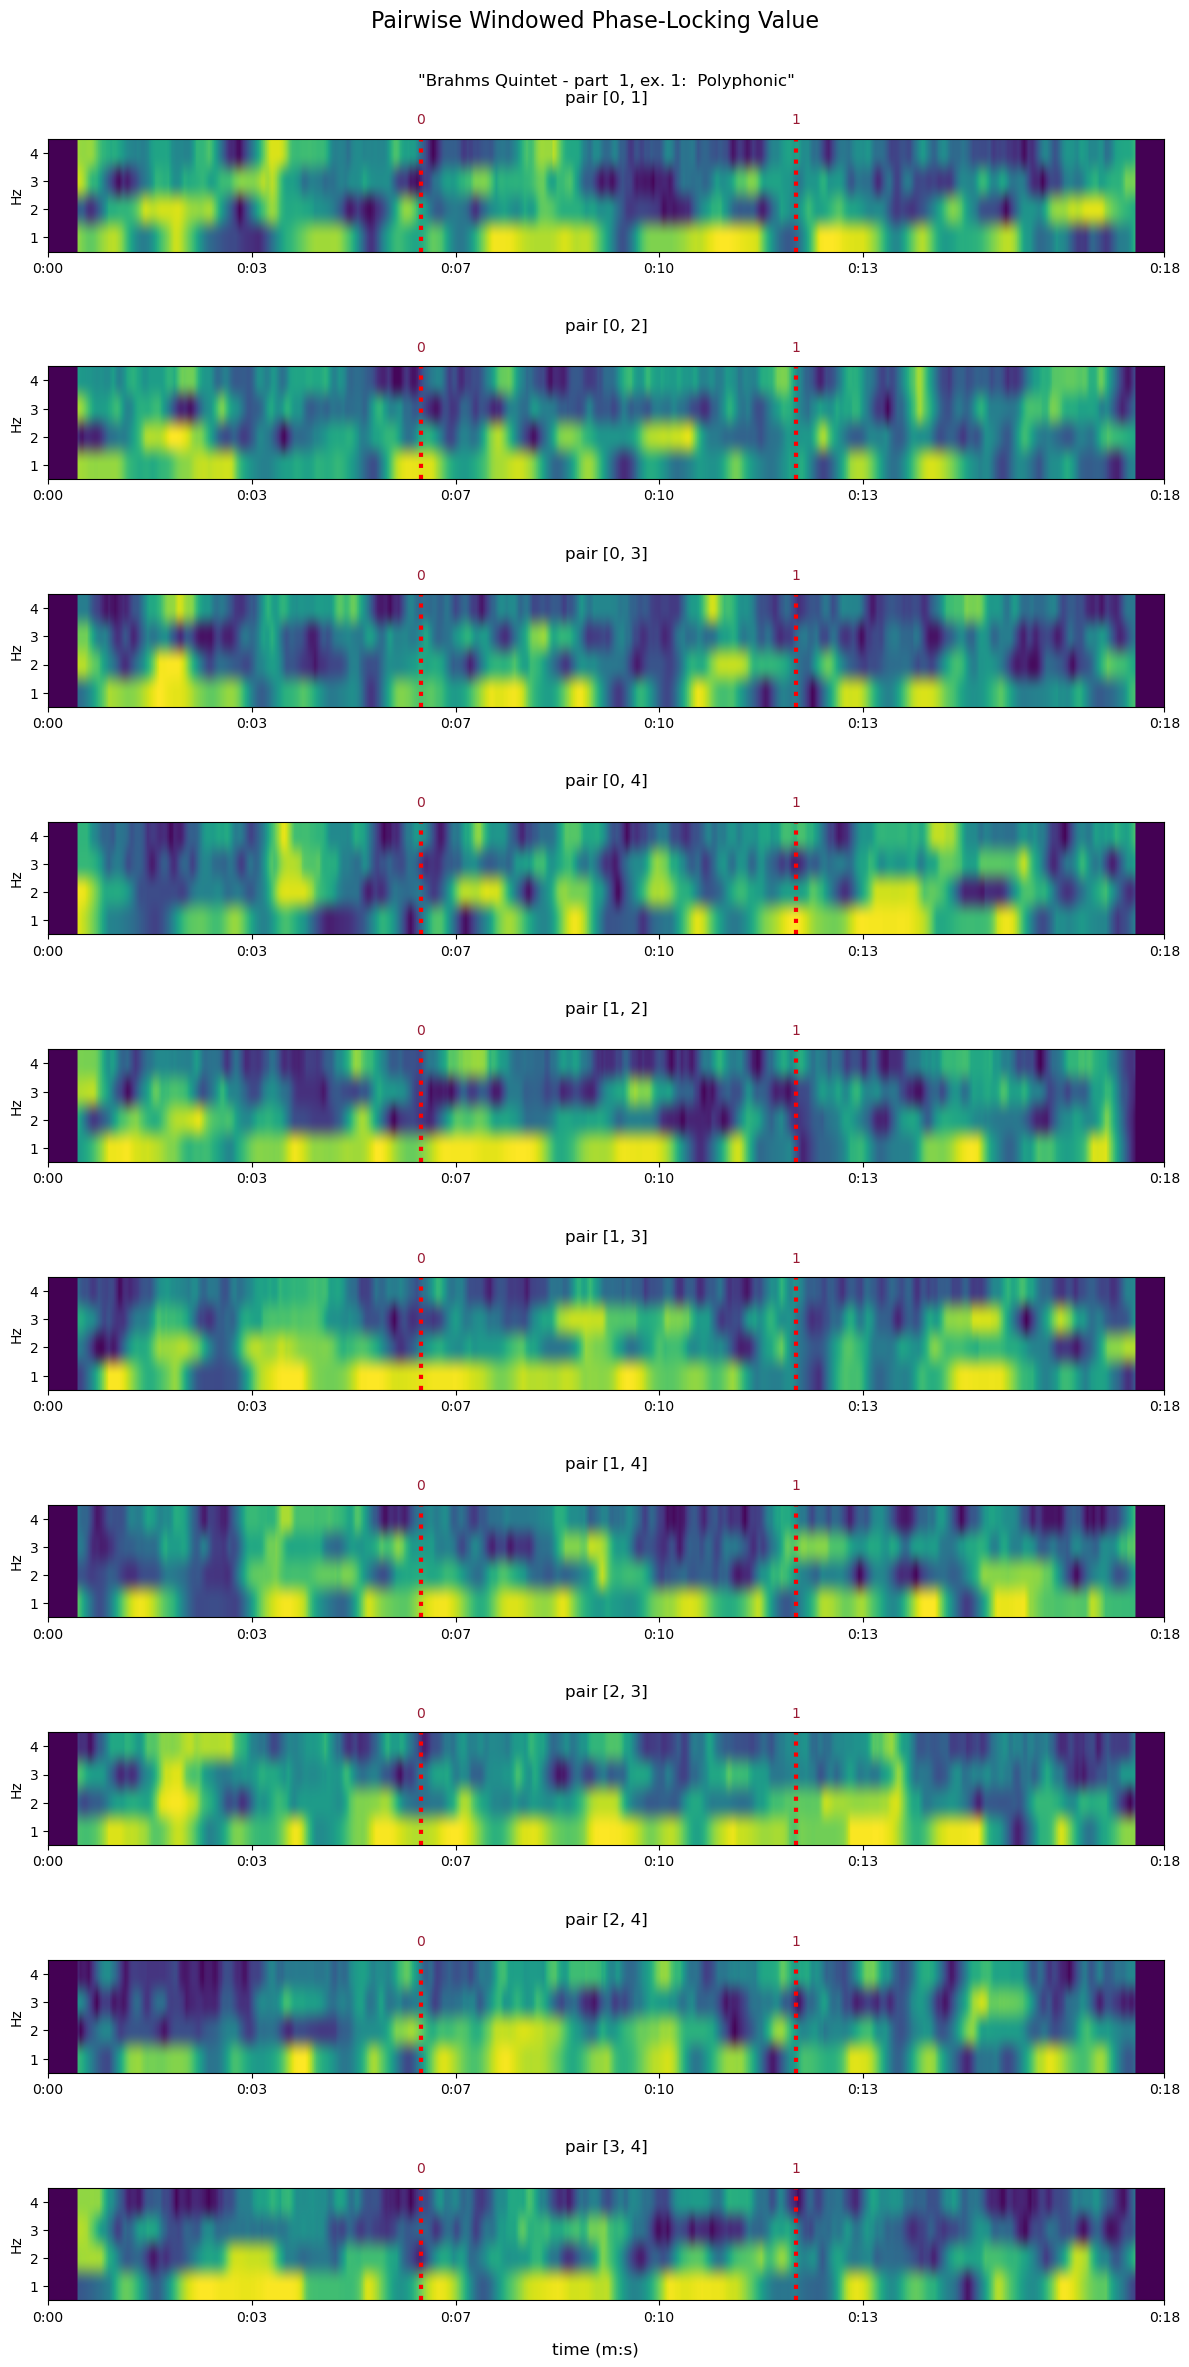

In [13]:
plv_win_s = fft_win_s
# plv_win_s = 30/data_fps # <--- PLV window length in seconds

plv_win_hop = None # <--- PLV window step in seconds
# plv_win_hop = 5/data_fps # <--- PLV window step in seconds

wplv_1 = sc.ptdata.winplv( phase, plv_win_s, window_hop=plv_win_hop, mode='same',
                           pairs_axis = 0, # pairs made of points (each point corresponds to a musician)
                           plv_axis = -1) # frames
pairs_labels = wplv_1.labels.dimel[0]
wplv_1.visualise( top=0 )

>
#### Aggregate frequency bins

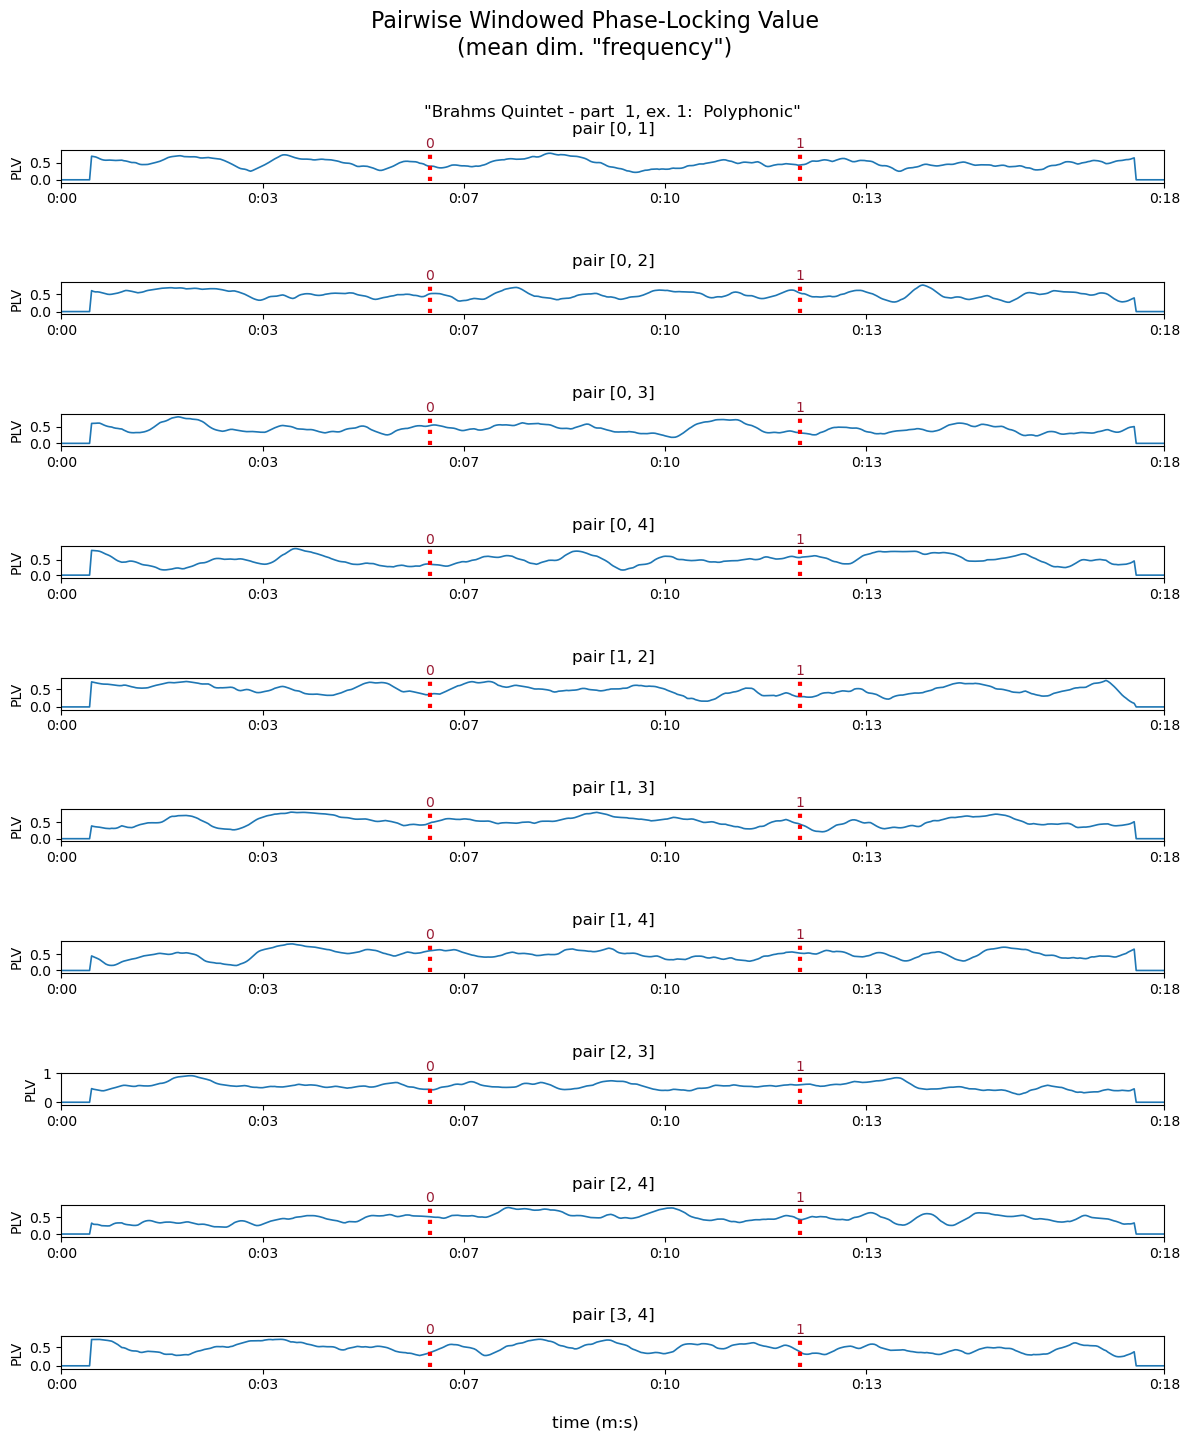

In [14]:
if wplv_1.names.dim[-2] == 'frequency':
    wplv_2 = sc.ptdata.aggrax( wplv_1, axis=-2, function='mean' )
    wplv_2.visualise( top=0, vscale=0.6, x_ticklabelling='s' )
else: wplv_2 = wplv_1

***
### Sections' PLV means

Sections correspond to positions ('Start','Middle','End') as in Sabharwal et al., (2022).

In [15]:
rescale_ylims = False # <--- rescale plots' vertical axes to [0,1]

if phase_method == 'peaks': sm_s = plv_win_s/2
elif phase_method == 'FFT': sm_s = fft_win_s/2

sec_margins = [[sm_s,sm_s] for _ in range(3)] # discard borders and sections' overlap
# sec_margins = [[sm_s,0],[0,0],[0,sm_s]] # discard only borders

sec_labels = ('Start','Middle','End')

def prettyplots(title, rs_ylim, sec_labels, rs_figsize=None):
    plt.suptitle(title, size=16)
    fig = plt.gcf()
    if rs_figsize:
        fsize = fig.get_size_inches()
        fig.set_size_inches(fsize[0]*rs_figsize[0], fsize[1]*rs_figsize[1])
    axes = fig.get_axes()
    for ax in axes:
        if rs_ylim: ax.set_ylim((0,1))
        ax.set_xlim((-0.2,2.2))
        ax.set_xticks((0,1,2), sec_labels, fontsize=12)
    plt.tight_layout()

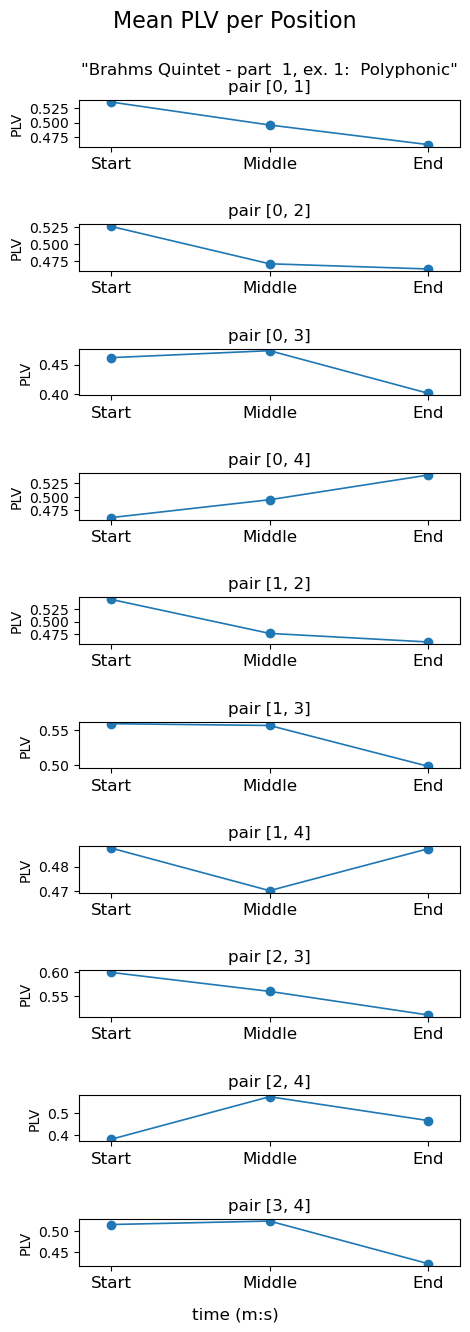

In [16]:
wplv_secmeans = sc.ptdata.secstats( wplv_2, margins=sec_margins, statnames='mean', last=True )
wplv_secmeans.visualise( top=0, vscale=0.55, hscale=0.4 )
prettyplots('Mean PLV per Position\n', False, sec_labels )

>
#### Rearrange and re-label data

For consistency with labels in Sabharwal et al., (2022), groups ('homophonic' or 'polyphonic') are labeled as  'texture', and sections ('Start','Middle','End') are labelled as 'position'.

In [17]:
# Rearrange PLV means:
secmeans_topstack = sc.ptdata.aggrtop( wplv_secmeans, function='vstack' ).data[0].T
excerpt_group_labels = wplv_secmeans.topinfo.Group.tolist()
n_excerpts = len(excerpt_group_labels)
n_pairs = len(pairs_labels)
n_sections = len(sec_labels)
means_dict = {}
pair_labels_phrases = [s for l in [pairs_labels for _ in range(n_excerpts)] for s in l]
means_dict['pair'] = [s for l in [pair_labels_phrases for _ in range(n_sections)] for s in l]
means_dict['PLV'] = np.array(secmeans_topstack.flat)
group_labels_phrases = [s for s in excerpt_group_labels for _ in range(n_pairs)]
means_dict['texture'] =  [s for l in [group_labels_phrases for _ in range(n_sections)] for s in l]
means_dict['position'] = [s for s in sec_labels for _ in range(n_pairs*n_excerpts)]
means_dict['duration'] = []
for i_sec in range(n_sections):
    for i_ex in range(n_excerpts):
        for i_p in range(n_pairs):
            means_dict['duration'].append(orig_seclens[i_ex,i_sec].item())

means_df = pd.DataFrame(means_dict)
means_df.head()

,pair,PLV,texture,position,duration
0,"pair [0, 1]",0.535484,Polyphonic,Start,183
1,"pair [0, 2]",0.525854,Polyphonic,Start,183
2,"pair [0, 3]",0.461669,Polyphonic,Start,183
3,"pair [0, 4]",0.461399,Polyphonic,Start,183
4,"pair [1, 2]",0.543953,Polyphonic,Start,183


In [18]:
def check_normality( df, keyname, keys, sw_alpha=0.05 ):
    len_keys = len(keys)
    if len_keys <= 3:
        n_row, n_col = 1, 3
        fig_height = 2
    else:
        n_row = int(np.ceil(np.sqrt(len_keys)))
        n_col = n_row
        fig_height = n_row*1.5
    plt.figure(figsize=(10,fig_height))
    for i_sp, this_lbl in enumerate(keys):
        v = df.PLV[df[keyname] == this_lbl]
        this_mean = np.nanmean(v)
        this_sw_test = stats.shapiro(v)
        if this_sw_test[1] >= sw_alpha: normality_lbl = 'normal'
        else: normality_lbl = 'non-normal'
        print(f'{this_lbl} (n={len(v)}):')
        print('  SW-test statistic = ',round(this_sw_test[0],4),
              ', p-value =',round(this_sw_test[1],4), f'({normality_lbl})')
        print('  mean =', round(this_mean,4))
        plt.subplot(n_row,n_col,i_sp+1)
        i_sp+=1
        plt.hist(v,bins=10), plt.title(this_lbl)
        plt.ylabel('$n$')
        plt.xlabel('$PLV$')
    plt.tight_layout()

>
#### Distribution of means grouped by sections ('position')

Start (n=240):
  SW-test statistic =  0.9908 , p-value = 0.1364 (normal)
  mean = 0.4923
Middle (n=240):
  SW-test statistic =  0.9938 , p-value = 0.4192 (normal)
  mean = 0.4938
End (n=240):
  SW-test statistic =  0.9941 , p-value = 0.4746 (normal)
  mean = 0.4939


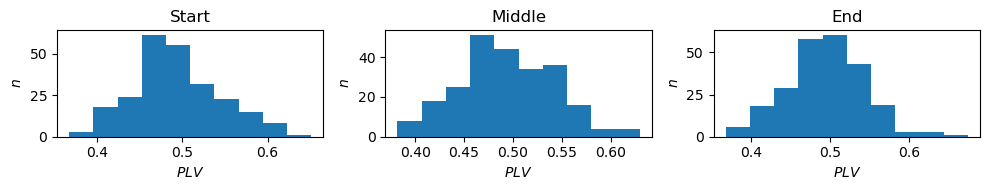

In [19]:
check_normality( means_df, 'position', sec_labels)

***
### Groups' PLV means

Groups correspond to textures ('Polyphonic','Homophonic') as in Sabharwal et al., (2022).

In [20]:
# select groups:
texture_labels = ('Polyphonic','Homophonic')
ptdata_groups_pairs = []
for tlbl in texture_labels:
    idx_group = wplv_secmeans.topinfo.index[wplv_secmeans.topinfo['Group']==tlbl].to_list()
    ptdata_groups_pairs.append( sc.ptdata.select( wplv_secmeans, top=idx_group ) )
    print(f'dimensions for {tlbl} =',ptdata_groups_pairs[-1].labels.dim)

dimensions for Polyphonic = ['pairs', 'sec.']
dimensions for Homophonic = ['pairs', 'sec.']


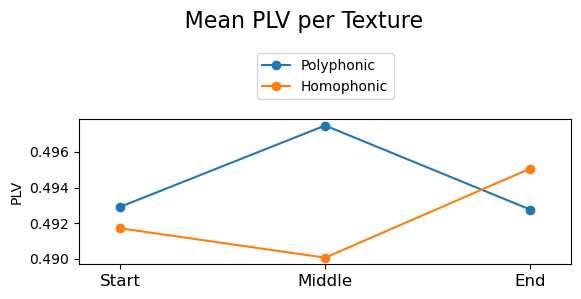

In [21]:
groupmeans = []
plt.figure(figsize=(6,3))
for d,lbl in zip(ptdata_groups_pairs,texture_labels):
    agg_pairs = sc.ptdata.aggrax( d, function='mean', axis=0 ) # aggregate pairs
    groupmeans.append( sc.ptdata.aggrtop( agg_pairs, function='mean' )) # aggregate phrases (top level data)
    plt.plot(groupmeans[-1].data[0],marker='o')

plt.ylabel('PLV')
plt.legend(texture_labels,bbox_to_anchor=(0.5, 1.5),loc='upper center')
plt.tight_layout()
prettyplots('     Mean PLV per Texture', False, sec_labels)

Polyphonic (n=360):
  SW-test statistic =  0.9956 , p-value = 0.4081 (normal)
  mean = 0.4944
Homophonic (n=360):
  SW-test statistic =  0.9913 , p-value = 0.0322 (non-normal)
  mean = 0.4923


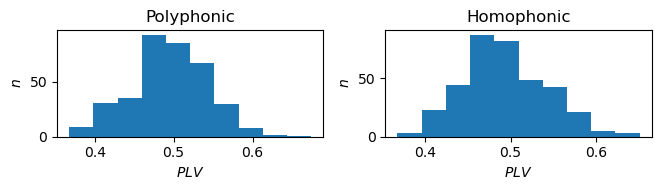

In [22]:
check_normality( means_df, 'texture', texture_labels)

>
#### Check durations per group ('texture')

In [23]:
print('Mean durations of phrases:')
for tlbl in texture_labels:
    mdur = means_df[means_df['texture']==tlbl].duration.mean()
    print(f'  {tlbl} =',round(mdur,4))

Mean durations of phrases:
  Polyphonic = 208.6667
  Homophonic = 216.0278


>
#### Check normality of PLV means grouped by duration


183 (n=20):
  SW-test statistic =  0.9789 , p-value = 0.9197 (normal)
  mean = 0.4891
276 (n=20):
  SW-test statistic =  0.9357 , p-value = 0.1984 (normal)
  mean = 0.4883
203 (n=40):
  SW-test statistic =  0.9486 , p-value = 0.0679 (normal)
  mean = 0.4904
175 (n=30):
  SW-test statistic =  0.9622 , p-value = 0.3514 (normal)
  mean = 0.4807
280 (n=20):
  SW-test statistic =  0.9032 , p-value = 0.0473 (non-normal)
  mean = 0.4872
272 (n=30):
  SW-test statistic =  0.9781 , p-value = 0.7741 (normal)
  mean = 0.4952
236 (n=40):
  SW-test statistic =  0.9406 , p-value = 0.0364 (non-normal)
  mean = 0.4942
193 (n=20):
  SW-test statistic =  0.9404 , p-value = 0.244 (normal)
  mean = 0.5078
169 (n=40):
  SW-test statistic =  0.9729 , p-value = 0.4427 (normal)
  mean = 0.4909
205 (n=20):
  SW-test statistic =  0.9597 , p-value = 0.5387 (normal)
  mean = 0.5032
161 (n=30):
  SW-test statistic =  0.9046 , p-value = 0.0109 (non-normal)
  mean = 0.4799
300 (n=20):
  SW-test statistic =  0.9346 ,

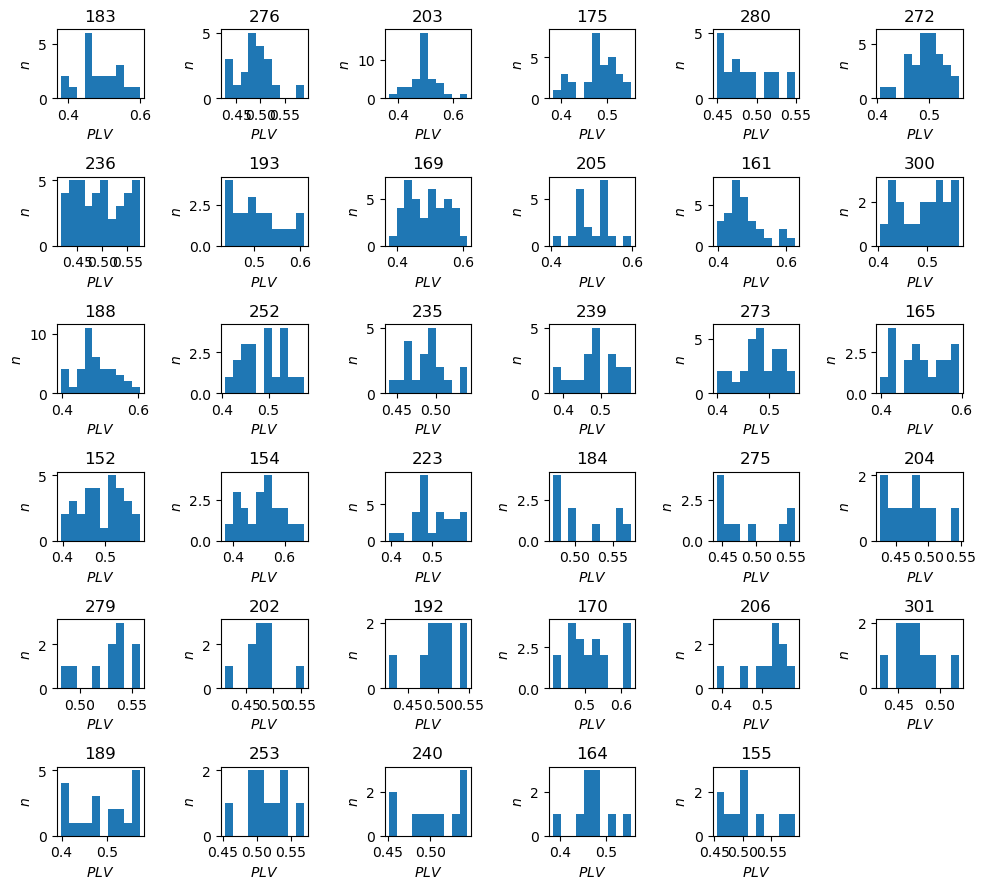

In [24]:
check_normality( means_df, 'duration', means_df.duration.unique())

***
### Analyses of Variance

F-test is suitable when the grouped data is normal or close to normal. Otherwise it is pertinent to use the H-test.

In [25]:
ols_model = smf.ols( formula='PLV ~ duration*texture + texture*position',
                     data=means_df).fit()
anova_between = sm.stats.anova_lm(ols_model, typ=1)
anova_between_disp = anova_between.iloc[:-1,:].copy()
anova_between_disp = anova_between_disp.rename(columns={'PR(>F)':'p'})
anova_between_disp = anova_between_disp[['F','p']]
print('Between-Subjects')
with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
    display(anova_between_disp)

Between-Subjects


,F,p
texture,0.326,0.568
position,0.077,0.926
texture:position,0.592,0.554
duration,0.255,0.614
duration:texture,1.205,0.273


In [26]:
anova_within = AnovaRM( data=means_df, depvar='PLV', subject='pair',
                        within=['texture','position'], aggregate_func='mean' ).fit()
anova_within_disp = anova_within.anova_table.copy()
anova_within_disp = anova_within_disp.rename(columns={'F Value':'F','Pr > F':'p'})
anova_within_disp = anova_within_disp[['F','p']]
print('Within-Subjects')
with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
    display(anova_within_disp)

Within-Subjects


,F,p
texture,0.495,0.500
position,0.109,0.898
texture:position,0.836,0.450


In [27]:
anova_nonpar_tex = stats.kruskal( means_df[means_df['texture']=='Polyphonic'].PLV,
                                  means_df[means_df['texture']=='Homophonic'].PLV )

anova_nonpar_pos = stats.kruskal( means_df[means_df['position']=='Start'].PLV,
                                  means_df[means_df['position']=='Middle'].PLV,
                                  means_df[means_df['position']=='End'].PLV )

duration_groups = []
for d in means_df.duration.unique():
    duration_groups.append(means_df[means_df['duration']==d].PLV.tolist())
anova_nonpar_dur = stats.kruskal( *duration_groups )
anova_nonpar_df = pd.DataFrame( [anova_nonpar_tex,anova_nonpar_pos,anova_nonpar_dur],
                                index=['texture','position','duration'],
                                columns=['H','p'])
print('Kruskal-Wallis')
with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
    display(anova_nonpar_df)

Kruskal-Wallis


,H,p
texture,0.886,0.346
position,0.452,0.798
duration,43.809,0.121


***
## Commentary

It was not possible to obtain the results reported by Sabharwal et al., (2022), neither by using similar parameters, nor by using alternative parameters and methods.

There is no significant effect of position, but with some combination of parameters (e.g., using frequency bins from 1 to 4 Hz when computing Phase ) there is a significant effect of texture and duration.
A significant effect of texture and duration was indeed reported by Sabharwal et al., using frequency bins from 1 to 10 Hz when computing Phase.
The significance of texture found in this replication might be due to the different durations of trials with either texture. The mean durations of textures are consistently correlated to the grand means of PLV, no matter what parameters or methods are used in the analysis.

These results may not be indicative of lack of synchronisation or viceversa. The results are only valid for the quantification methods used.